## Demonstrating Perceptron Failure on XOR Problem,
    
The XOR (exclusive OR) problem is a classic example where a single-layer perceptron fails. This is because the XOR function is not linearly separable, meaning you cannot draw a single straight line to separate the '0' outputs from the '1' outputs.,

The XOR truth table is:
| x1 | x2 | y |
|----|----|---|
| 0  | 0  | 0 |
| 0  | 1  | 1 |
| 1  | 0  | 1 |
| 1  | 1  | 0 |

Let's try to train our perceptron on this task.

The discussion of the Xor problem by Minsky et Papert led to the first AI-Winter from 1969-1986 see more on https://en.wikipedia.org/wiki/Perceptrons_(book), which ended with the inventation of the multilayer networks with backpropagation (hinton et al.)


Nevertheless the XOR problem was solved long time with a multilayer architecture, there are some approaches that use a single layer Solution such as: https://arxiv.org/html/2409.10821v1 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

%config InlineBackend.figure_format='retina'

from src.utils.plot import plot_examples, plot_metrics
from src.preprocessing.data_transforms import normalize, one_hot_encoding, shuffle_data

from src.models.perceptron import Perceptron
from src.components.loss import mse_loss
from src.components.blocks import compute_weighted_sum
from src.components.initializers import initialize_randn_weights

<function initialize_randn_weights at 0x117b46200>


In [2]:
# 1. Define XOR data as 28x28 images
img_size = 28
square_size = img_size // 2
X_xor_images = []

# Image for (0,0) -> Output 0 (All black)
img_00 = np.zeros((img_size, img_size), dtype=np.float32)
X_xor_images.append(img_00.flatten())

# Image for (0,1) -> Output 1 (Top-right square)
img_01 = np.zeros((img_size, img_size), dtype=np.float32)
img_01[:square_size, -square_size:] = 1
X_xor_images.append(img_01.flatten())

# Image for (1,0) -> Output 1 (Bottom-left square)
img_10 = np.zeros((img_size, img_size), dtype=np.float32)
img_10[-square_size:, :square_size] = 1
X_xor_images.append(img_10.flatten())

# Image for (1,1) -> Output 0 (Top-left and Bottom-right squares)
img_11 = np.zeros((img_size, img_size), dtype=np.float32)
img_11[:square_size, -square_size:] = 1
img_11[-square_size:, :square_size] = 1

X_xor_images.append(img_11.flatten())

X_xor = np.array(X_xor_images, dtype=np.float32)

# XOR labels remain the same
y_xor = np.array([0, 1, 1, 0], dtype=np.int8)

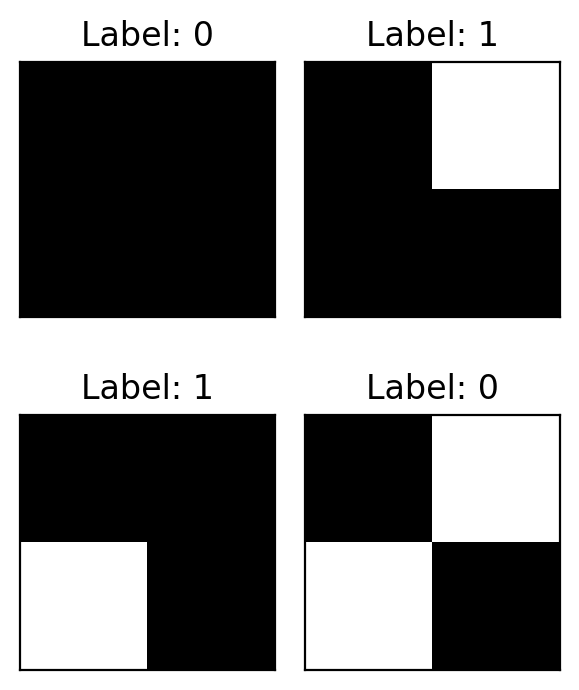

In [3]:
plot_examples(
    X_xor.reshape(-1, img_size, img_size),
    labels=y_xor,
    num_row=2,
    num_col=2,
)

06/06/2025 22:57:38 Starting training for 100 epochs
06/06/2025 22:57:38 Epoch 0: Loss: 3.0000, Accuracy: 0.2500


06/06/2025 22:57:38 Epoch 10: Loss: 2.0000, Accuracy: 0.5000
06/06/2025 22:57:38 Epoch 20: Loss: 3.0000, Accuracy: 0.2500
06/06/2025 22:57:38 Epoch 30: Loss: 2.0000, Accuracy: 0.5000
06/06/2025 22:57:38 Epoch 40: Loss: 2.0000, Accuracy: 0.5000
06/06/2025 22:57:38 Epoch 50: Loss: 2.0000, Accuracy: 0.5000
06/06/2025 22:57:38 Epoch 60: Loss: 3.0000, Accuracy: 0.2500
06/06/2025 22:57:38 Epoch 70: Loss: 2.0000, Accuracy: 0.5000
06/06/2025 22:57:38 Epoch 80: Loss: 3.0000, Accuracy: 0.2500
06/06/2025 22:57:38 Epoch 90: Loss: 2.0000, Accuracy: 0.5000
06/06/2025 22:57:38 Epoch 99: Loss: 3.0000, Accuracy: 0.2500


(4, 784)


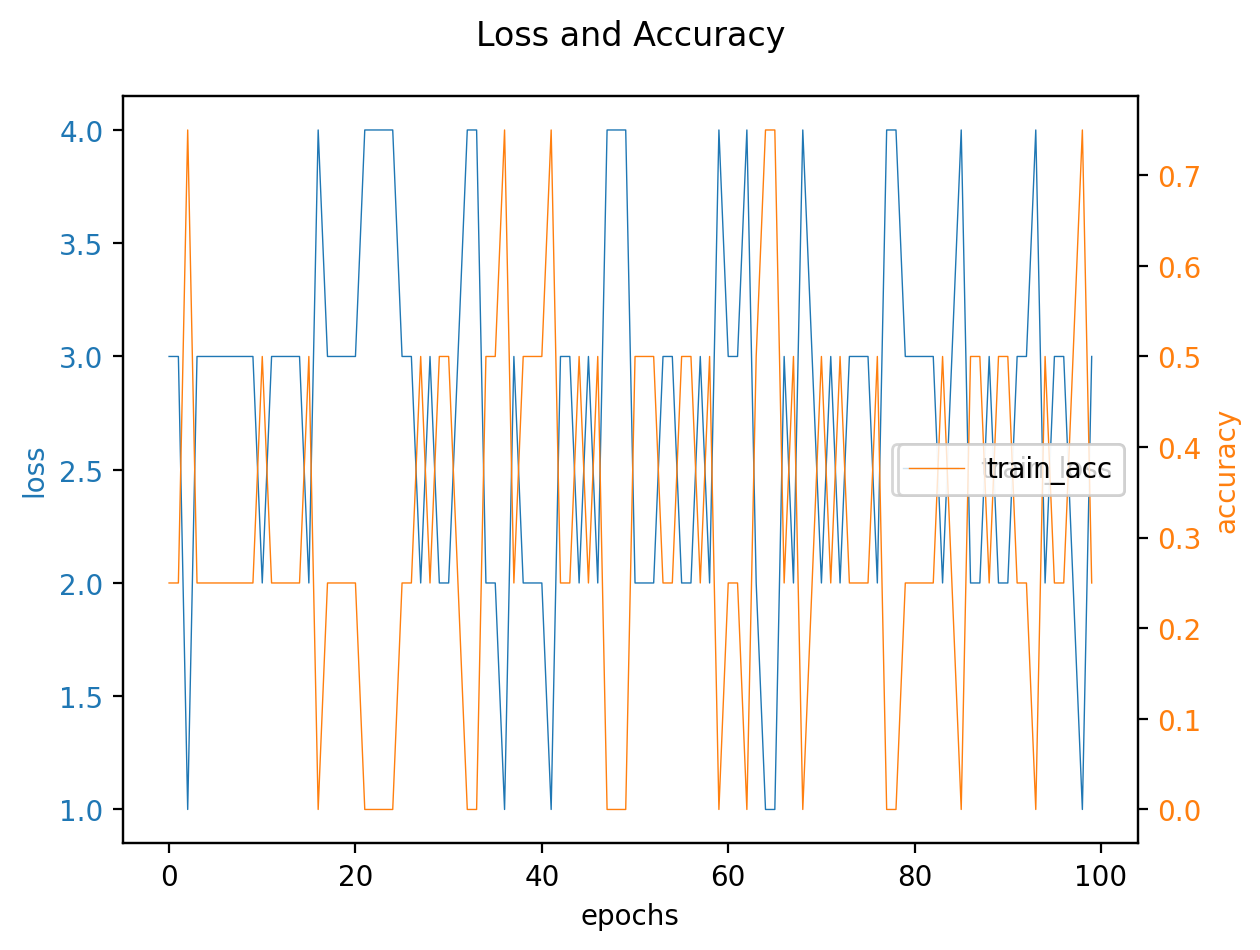

In [ ]:
# train the perceptron
perceptron = Perceptron(initializer="zero")
perceptron.fit(
    X_xor, y_xor, epochs=100, learning_rate=0.001, plot_metrics=True, threshold=0.5
)

In [5]:
perceptron.eval(X_xor.reshape(-1, img_size, img_size), y_xor)

np.float64(0.5)

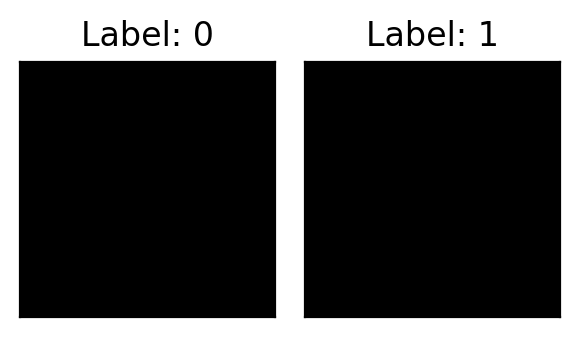

In [6]:
# Let's inspect the weights / latent space of the perceptron for each class
# we can visualize the weights as images

plot_examples(
    [weights[:-1].reshape(28, -1) for weights in perceptron.weights],
    labels=np.arange(2),
    num_row=1,
    num_col=2,
)

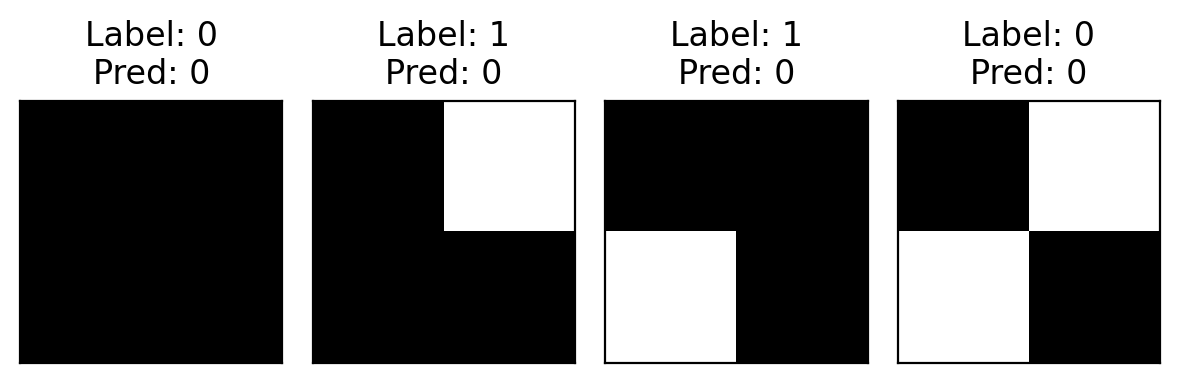

In [ ]:
plot_examples(
    X_xor.reshape(-1, img_size, img_size),
    labels=y_xor,
    predictions=[
        perceptron.predict(image, threshold=0.5)
        for image in X_xor.reshape(-1, img_size, img_size)
    ],
    num_col=4,
    num_row=1,
)

As you'll likely see from the output, the accuracy for the XOR problem will not reach 100%. It might hover around 50% or 75%, depending on the final weights. This is because a single perceptron can only form a linear decision boundary (a straight line in 2D), and XOR requires a non-linear boundary to perfectly separate the classes.

## Try to solve the XOR problem with a single layer neuron and PReLU activation function

Note: There is a important difference in the learning rules to the perceptron and the classic Adaline Network: The Perceptron updates the weights according to the output *after* the step function, while the Adaline Network updates the weights according to the output *before* the step function but using a mse-loss. The PReLU Network below updates the weights after the activation function but using a mse-loss as well. Therefore it is rather a very simple single layer network.

prelu alpha=0.1: [[-0.1  0.   1. ]]
prelu alpha=-0.3: [[ 0.3 -0.   1. ]]
prelu_diff: [[0.1 0.1 1. ]]
prelu_diff_alpha: [[-1.  0.  0.]]

prelu: [[-0.1  0.   1. ]]
prelu_diff: [[0.1 0.1 1. ]]
prelu_diff_alpha: [[-1.  0.  0.]]


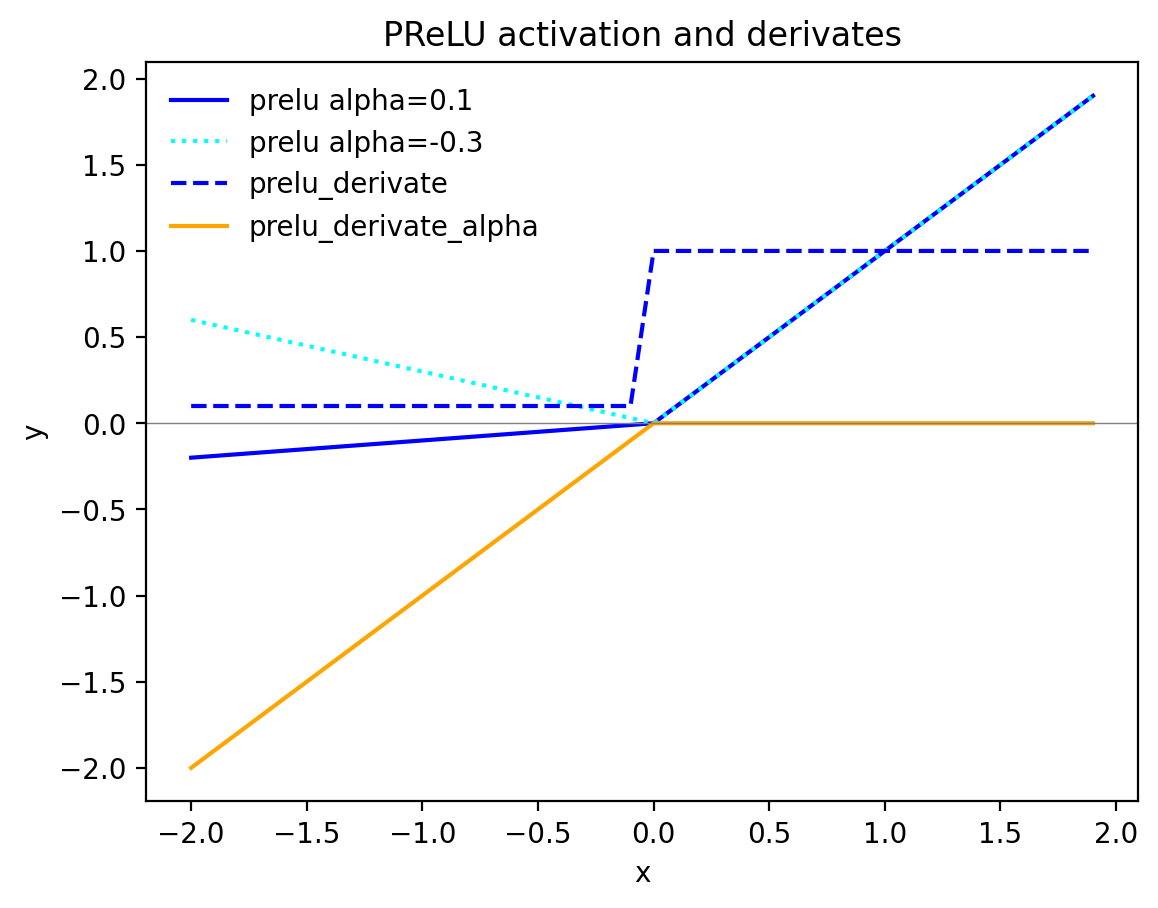

In [8]:
# define activation function


def prelu(x: np.ndarray, alphas: np.ndarray) -> np.ndarray:
    """Parametric ReLu activation function, with learnable alpha.

    Args:
        x (np.ndarray): input array
        alpha (np.ndarray): learnable alphas

    Returns:
        np.ndarray: output array
    """
    return np.where(x > 0, x, alphas * x)


def prelu_backward(x: np.ndarray, alphas: np.ndarray) -> np.ndarray:
    """Derivate of the Parametric ReLu activation function, with learnable alpha.

    Args:
        x (np.ndarray): input array
        alpha (np.ndarray): learnable alphas

    Returns:
        np.ndarray: output array
    """
    return np.where(x > 0, 1, alphas)


def prelu_derivate_alpha(x: np.ndarray):
    """Derivate of the Parametric ReLu activation function wrt. alpha.

    Args:
        x (np.ndarray): input array

    Returns:
        np.ndarray: output array
    """
    return np.where(x > 0, 0, x)


test_array = np.array([[-1.0, 0.0, 1.0]])

print(
    f"prelu alpha=0.1: {prelu(test_array, alphas=np.array([0.1]))}\nprelu alpha=-0.3: {prelu(test_array, alphas=np.array([-0.3]))}\nprelu_diff: {prelu_backward(test_array, np.array([0.1]))}\nprelu_diff_alpha: {prelu_derivate_alpha(test_array)}\n\nprelu: {prelu(test_array, 0.1)}\nprelu_diff: {prelu_backward(test_array, 0.1)}\nprelu_diff_alpha: {prelu_derivate_alpha(test_array)}"
)

example_data = np.arange(-2.0, 2.0, 0.1)
plt.plot(example_data, prelu(example_data, np.array([0.1])), color="blue")
plt.plot(
    example_data,
    prelu(example_data, np.array([-0.3])),
    color="cyan",
    linestyle="dotted",
)
plt.plot(example_data, prelu_backward(example_data, 0.1), color="blue", linestyle="--")
plt.plot(example_data, prelu_derivate_alpha(example_data), color="orange")

plt.title("PReLU activation and derivates")
plt.xlabel("x")
plt.ylabel("y")
plt.axhline(0, color="gray", linewidth=0.5)
# plt.hlines(y=0, xmax=2, xmin=-2, color="grey", linewidth=0.2)
plt.legend(
    labels=[
        "prelu alpha=0.1",
        "prelu alpha=-0.3",
        "prelu_derivate",
        "prelu_derivate_alpha",
    ],
    frameon=False,
)
plt.show()

In [9]:
idx2label = {0: 0, 1: 1}
label2idx = idx2label
weights = initialize_randn_weights(X_xor[0].shape[0], 2, bias_size=1)

In [10]:
def predict_prelu(
    transformed_image, weights, alphas, idx2label=None, bias_size=1, backward=False
) -> Tuple[np.ndarray, np.ndarray] | int:
    # binary classifier case
    if len(weights.shape) == 1:
        weighted_sum = compute_weighted_sum(
            transformed_image, weights, bias_size=bias_size
        )
        preds = prelu(weighted_sum, alphas)

        return (preds, weighted_sum) if backward else int(round(preds.item(), 0))

    # multi-class classifier case. Here we are broadcasting the calculations
    else:
        weighted_sums = compute_weighted_sum(
            transformed_image, weights.T, bias_size=bias_size
        )
        preds = prelu(weighted_sums, alphas)

        return (preds, weighted_sums) if backward else np.argmax(preds)


predict_prelu(
    X_xor[0], weights, alphas=np.array([1]), idx2label=idx2label, backward=False
)

1

In [ ]:
def backward_pass_prelu(
    transformed_image: np.ndarray,
    y: np.ndarray,
    weights: np.ndarray,
    alphas: np.ndarray,
    learning_rate: float = 0.01,
    learning_rate_alpha: float = 0.0001,
    bias_size: int = 1,
) -> Tuple[np.ndarray, np.ndarray, float, int]:
    """backward_pass_prelu calculates the parameter updates (weights and alphas) and returns the loss & preds.

    Args:
        transformed_image (np.ndarray): transformed image
        y (np.ndarray): label
        weights (np.ndarray): weights
        alphas (np.ndarray): alphas
        learning_rate (float, optional): learning rate. Defaults to 0.01.
        learning_rate_alpha (float, optional): learning rate for alpha. Defaults to 0.0001.
        bias_size (int, optional): bias size. Defaults to 1.

    Returns:
        tuple: weights, alphas, loss, preds
    """

    if len(weights.shape) == 1:
        preds, weighted_sum = predict_prelu(
            transformed_image,
            weights,
            alphas,
            idx2label,
            bias_size=bias_size,
            backward=True,
        )

        error_signal = preds - label2idx.get(y)
        grad_alpha = error_signal * prelu_derivate_alpha(weighted_sum)

        grad_weights = (
            np.hstack((transformed_image, np.ones(bias_size)))
            * error_signal
            * prelu_backward(weighted_sum, alphas)
        )

        alphas -= learning_rate_alpha * grad_alpha
        weights -= learning_rate * grad_weights

        loss = mse_loss(preds, label2idx.get(y))
        preds = int(round(preds.item(), 0))

    else:
        num_classes = weights.shape[0]
        y_encoded = one_hot_encoding(y, num_classes)

        preds, weighted_sums = predict_prelu(
            transformed_image,
            weights,
            alphas,
            idx2label,
            bias_size=bias_size,
            backward=True,
        )

        error_signal = preds - y_encoded

        grad_alpha = error_signal * prelu_derivate_alpha(weighted_sums)
        grad_weights = np.stack(
            [np.hstack((transformed_image, np.ones(bias_size)))] * num_classes
        ) * (error_signal * prelu_backward(weighted_sums, alphas)).reshape(
            num_classes, 1
        )

        alphas -= learning_rate_alpha * grad_alpha
        weights -= learning_rate * grad_weights

        loss = mse_loss(np.argmax(preds), y)
        preds = np.argmax(preds)

    return weights, alphas, loss, preds


weights, alphas, loss, preds = backward_pass_prelu(
    X_xor[0],
    y_xor[0],
    weights,
    np.array([0.1]),
    learning_rate=0.01,
    learning_rate_alpha=0.0001,
    bias_size=1,
)
print(weights.shape, alphas, loss, preds)

(785,) [0.1] 0.30401437635518985 1


Epoch 0: Loss: 0.2510, Accuracy: 0.5000
Epoch 7: Loss: 0.1536, Accuracy: 0.7500
Epoch 14: Loss: 0.1406, Accuracy: 0.7500
Epoch 21: Loss: 0.1309, Accuracy: 0.7500
Epoch 28: Loss: 0.1222, Accuracy: 0.7500
Epoch 35: Loss: 0.1129, Accuracy: 0.7500
Epoch 42: Loss: 0.1000, Accuracy: 0.7500
Epoch 49: Loss: 0.0822, Accuracy: 0.7500
Epoch 56: Loss: 0.0625, Accuracy: 0.7500
Epoch 63: Loss: 0.0474, Accuracy: 0.7500
Epoch 69: Loss: 0.0402, Accuracy: 1.0000


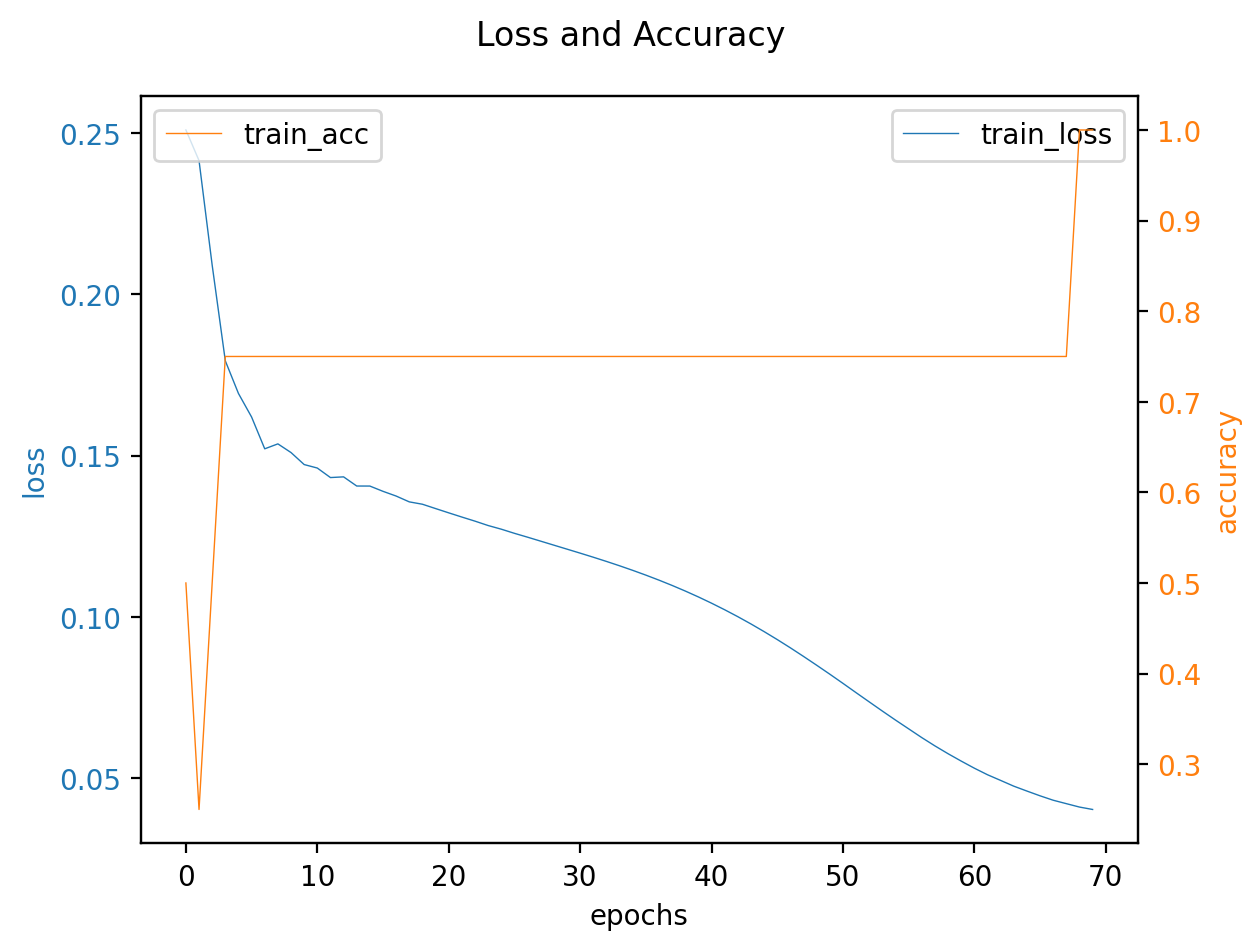

In [12]:
def train_prelu(
    X_train,
    y_train,
    epochs=10,
    learning_rate=0.01,
    learning_rate_alpha=0.0001,
    bias_size=1,
):
    w_len = X_train[0].flatten().shape[0]
    n_classes = np.unique(y_train).shape[0]
    n_examples = X_train.shape[0]

    # initialize the weights
    weights = initialize_randn_weights(w_len, n_classes, bias_size, 0.0, 0.01)
    alphas = (
        initialize_randn_weights(n_classes, 2, 0, 0.1, 0.01)
        if n_classes > 2
        else initialize_randn_weights(n_classes, 2, 0, 0.1, 0.01)[:-1]
    )

    train_metrics = {"loss": np.zeros(epochs), "accuracy": np.zeros(epochs)}
    X_train = normalize(X_train, 0, 1)

    for epoch in range(epochs):
        X_train, y_train = shuffle_data(X_train, y_train)

        # epoch metrics
        epoch_loss = 0
        correct_preds = 0

        # iterate over the training data
        for image, label in zip(X_train, y_train):
            # flatten the image
            transformed_image = image.flatten()

            weights, alphas, loss, pred = backward_pass_prelu(
                transformed_image,
                label,
                weights,
                alphas,
                learning_rate,
                learning_rate_alpha,
                bias_size,
            )

            epoch_loss += loss
            # pred = predict_prelu(transformed_image, weights, alphas, idx2label, bias_size=bias_size, backward=False)

            if label == pred:
                correct_preds += 1

        # compute the epoch metrics
        epoch_loss /= n_examples
        epoch_accuracy = correct_preds / n_examples

        # save the metrics
        train_metrics["loss"][epoch] = epoch_loss
        train_metrics["accuracy"][epoch] = epoch_accuracy

        if epoch % (epochs // 10 if epochs >= 10 else 1) == 0 or epoch == epochs - 1:
            print(
                f"Epoch {epoch}: Loss: {epoch_loss:.4f}, Accuracy: {train_metrics['accuracy'][epoch]:.4f}"
            )
    return weights, alphas, train_metrics


weights, alphas, train_metrics = train_prelu(
    X_xor.reshape(-1, img_size, img_size),
    y_xor,
    epochs=70,
    learning_rate=0.0025,
    learning_rate_alpha=0.005,
)
plot_metrics(train_metrics)

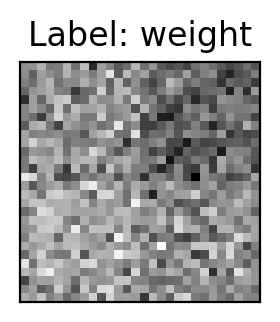

In [13]:
# Let's inspect the weights / latent space of the perceptron for each class
# we can visualize the weights as images

plot_examples(
    [weights[:-1].reshape(28, -1)],
    labels=["weight"],
    num_row=1,
    num_col=1,
)

In [14]:
# Let's inspect the weights / latent space of the perceptron for each class
# we can visualize the weights as images

alphas

array([-0.23273246])

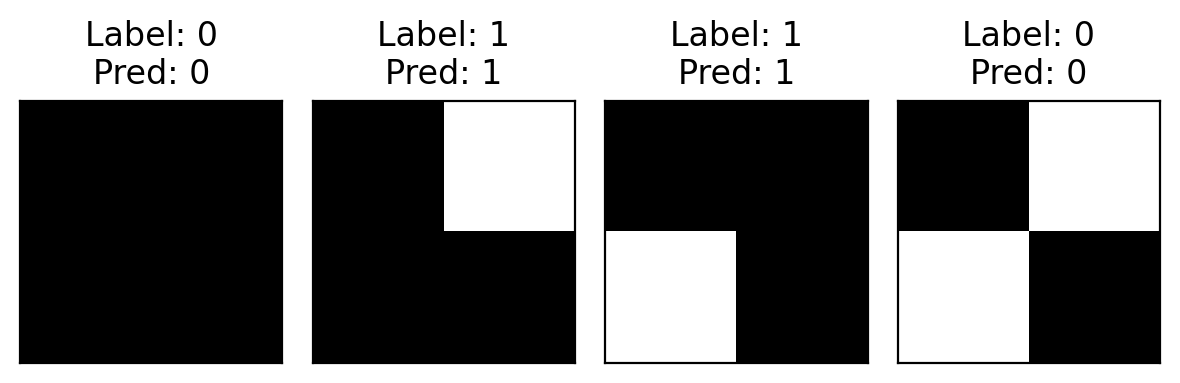

In [15]:
plot_examples(
    X_xor.reshape(-1, img_size, img_size),
    labels=y_xor,
    predictions=[
        predict_prelu(
            normalize(image, 0, 1).flatten(), weights, alphas, idx2label=idx2label
        )
        for image in X_xor.reshape(-1, img_size, img_size)
    ],
    num_col=4,
    num_row=1,
)

In [16]:
# Try it with the mnist set

from src.utils.load_data import mnist

train_images, train_labels, test_images, test_labels = mnist()

Dataset MNIST
    Number of datapoints     
    Train:  60000
    Test:   10000
    Source: https://ossci-datasets.s3.amazonaws.com/mnist/



Epoch 0: Loss: 1.1082, Accuracy: 0.8772
Epoch 2: Loss: 0.8366, Accuracy: 0.9069
Epoch 4: Loss: 0.8007, Accuracy: 0.9102
Epoch 6: Loss: 0.7863, Accuracy: 0.9128
Epoch 8: Loss: 0.7826, Accuracy: 0.9128
Epoch 10: Loss: 0.7732, Accuracy: 0.9142
Epoch 12: Loss: 0.7542, Accuracy: 0.9152
Epoch 14: Loss: 0.7493, Accuracy: 0.9159
Epoch 16: Loss: 0.7436, Accuracy: 0.9167
Epoch 18: Loss: 0.7495, Accuracy: 0.9157
Epoch 19: Loss: 0.7302, Accuracy: 0.9172


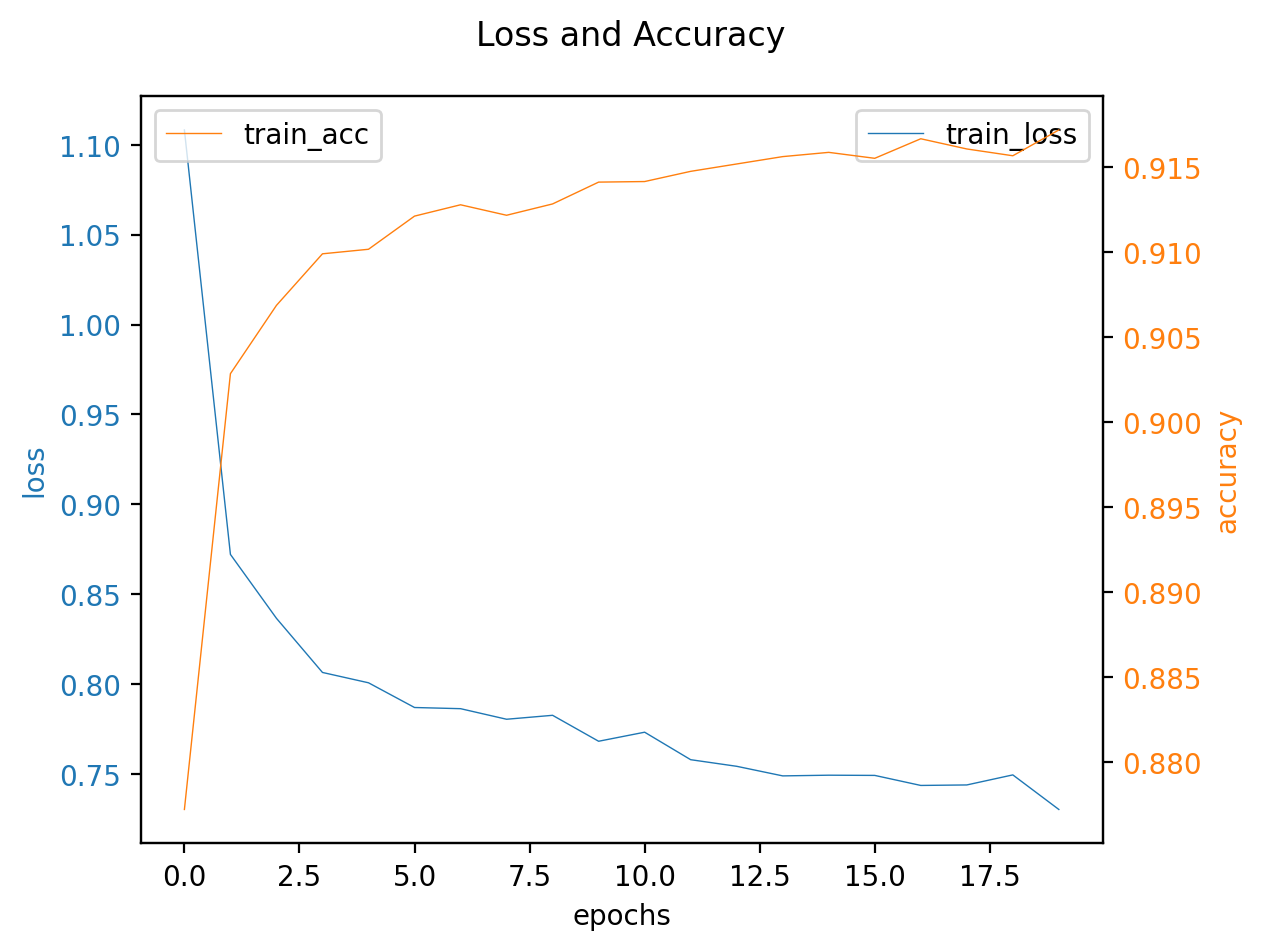

In [17]:
weights, alphas, train_metrics = train_prelu(
    train_images,
    train_labels,
    epochs=20,
    learning_rate=0.0007,
    learning_rate_alpha=0.0005,
)
plot_metrics(train_metrics)

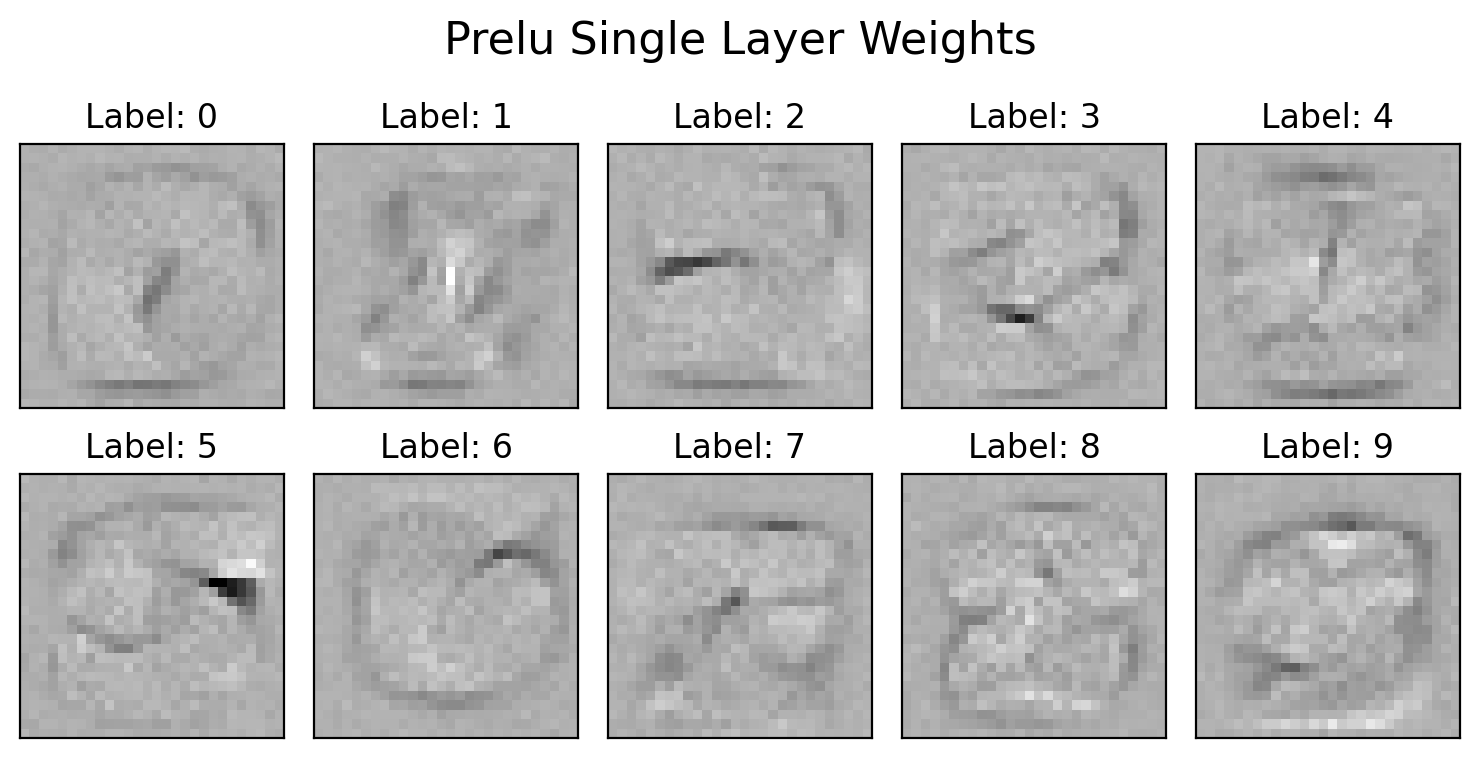

In [18]:
bias_size = 1

plot_examples(
    [weight[:-bias_size].reshape(28, -1) for weight in weights],
    labels=np.arange(len(weights)),
    fig_title="Prelu Single Layer Weights",
    # vmin=0,
    # vmax=1,  # 0.05 is the max to see it in a nice plot
)

In [19]:
alphas

array([-0.00029307, -0.00061115, -0.00419917, -0.0048263 , -0.00134861,
       -0.00564332, -0.00136177, -0.00012664, -0.00891955, -0.00115784])

In [20]:
def eval_prelu(X_test, y_test, weights, alphas, bias_size=1):
    n_examples = X_test.shape[0]
    correct_preds = 0
    transformed_image = normalize(X_test, 0, 1)

    for image, label in zip(transformed_image, y_test):
        pred = predict_prelu(image.flatten(), weights, alphas)
        if label == pred:
            correct_preds += 1

    return correct_preds / n_examples


print(f"Accuracy: {eval_prelu(test_images, test_labels, weights, alphas):.3f}")

Accuracy: 0.918


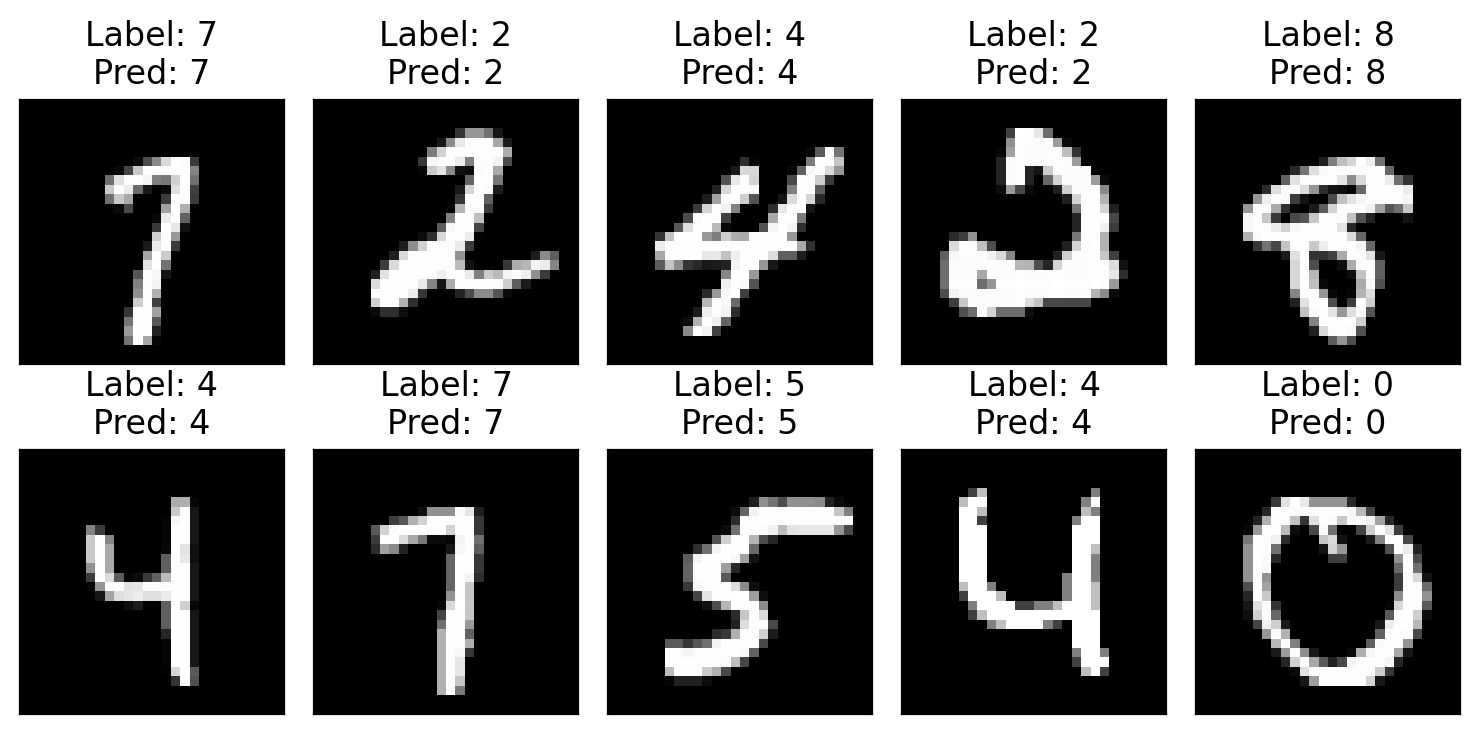

In [21]:
test_images, test_labels = shuffle_data(test_images, test_labels)

plot_examples(
    test_images[:10],
    labels=test_labels[:10],
    predictions=[
        predict_prelu(normalize(image, 0, 1).flatten(), weights, alphas, bias_size=1)
        for image in test_images[:10]
    ],
)